# Imports

In [161]:
import numpy as np
import pandas as pd
import psycopg2 as pg
import sweetviz as sv
import seaborn as sns
import scikitplot as skplt
import warnings
import pickle
import json
import requests
import inflection
warnings.filterwarnings('ignore')

from IPython.core.display import HTML
from IPython.display import Image
from matplotlib import pyplot as plt
from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import neighbors as nh
from sklearn import linear_model as lm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, plot_confusion_matrix
import xgboost as xgb
import lightgbm as lgb

## Helper Functions

In [162]:
def pie_chart(data,att,title,legend_title):
    
    def data_detail(pct, allvalues):
        absolute = int(pct/ 100.*np.sum(allvalues['response']))
        return "{:.0f}\n({:.1f}%)".format(absolute, pct)

    wedges, texts, autotexts = plt.pie( data = data,
                                       x = 'response',
                                       autopct = lambda pct: data_detail(pct, data),
                                       textprops = dict(color="w"))
    
    plt.legend( wedges, list(data[att]),
              title = legend_title,
              loc="center left",
              bbox_to_anchor = (1, 0, 0.5, 1))
    plt.setp(autotexts, size=10, weight="bold")
    plt.title(title,fontsize = 15);
    
def jupyter_settings():
    %matplotlib inline
    %pylab inline
#     plt.style.use( 'bmh' )
#     plt.rcParams['figure.figsize'] = [25, 12]
#     plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = 50
    pd.options.display.max_rows = 50
    pd.set_option( 'display.expand_frame_repr', False )
#     sns.set()
    
jupyter_settings()

def return_interest_perc(df,calls):
    perc = 100 * calls / len(df)
    return results[results['base_cum_perc'] <= perc]['real_cum_perc'].max()

def precision_at_k(data, k):
    
    # reset index
    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1

    data['precision_at_k'] = data['response'].cumsum()/data['ranking']

    return data.loc[k,'precision_at_k']

def recall_at_k(data, k):

    # reset index
    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1

    data['recall_at_k'] = data['response'].cumsum()/data['response'].sum()

    return data.loc[k,'recall_at_k']

def ranking_performance(model_name, x_validation, y_validation, yhat,top_k):

    data = x_validation.copy()
    data['response'] = y_validation.copy()

    # Propensity score
    data['score'] = yhat[:,1].tolist()

    # sort clients by propensity score
    data = data.sort_values('score',ascending=False)
    
    return pd.DataFrame(
        {'Model Name': model_name,
        'Precision at K': precision_at_k(data,k=top_k),
        'Recall at K': recall_at_k(data,k=top_k)},
        index=[0]
    )

def classification_performance(model_name, y_test, y_pred):
    acc = accuracy_score(y_test,y_pred)
    pre = precision_score(y_test,y_pred)
    rec = recall_score(y_test,y_pred)
    f1s = f1_score(y_test,y_pred)
    
    return pd.DataFrame({
        'Model':model_name,
        'Accuracy' : acc,
        'Precision': pre,
        'Recall': rec,
        'F1 Score': f1s}, index=[0])

def data_preparation(data,dict_preparation):
    for att in list(dict_preparation['STANDARIZATION'].keys()):
        std = dict_preparation['STANDARIZATION'][att]
        data.loc[:,att] = std.transform(data[[att]].values)

    for type_encode in list(dict_preparation['RESCALING'].keys()):
        for att in list(dict_preparation['RESCALING'][type_encode].keys()):
            std = dict_preparation['RESCALING'][type_encode][att]
            data.loc[:,att] = std.transform(data[[att]].values)

    for type_encode in list(dict_preparation['ENCONDING'].keys()):
        for att in list(dict_preparation['ENCONDING'][type_encode].keys()):
            if type_encode == 'one_hot_enconding':
                prefix = dict_preparation['ENCONDING'][type_encode][att]
                columns = dict_preparation['ENCONDING'][type_encode][att]
                data = pd.get_dummies(data, prefix = prefix,columns=[columns])
            else:
                std = dict_preparation['ENCONDING'][type_encode][att]
                data.loc[:,att] = data.loc[:,att].map(std)
                
    # fillna
    data = data.fillna(0)
                
    return data

def cross_validation(data_train,k_fold,model_name, model,verbose):

    validation_size = int(round(data_train.shape[0]*0.2,0))
    
    precision_at_k_list = []
    recall_at_k_list = []

    for k in range(0,k_fold):

        start_validation = validation_size*k
        end_validation   = validation_size*(k+1)
        range_validation = arange(start_validation,end_validation)
        range_data       = arange(0,data_train.shape[0])

        validation = data_train.iloc[ start_validation:end_validation ]
        training = data_train[ ~isin(range_data,range_validation)]

        x_training = training.drop(['id','response'],axis=1)
        y_training = training['response'].copy()

        x_validation = validation.drop(['id','response'],axis=1)
        y_validation = validation['response'].copy()

        # model fit
        m = model.fit(x_training,y_training)

        # model predict
        y_hat = m.predict_proba(x_validation)
        
        data_val = x_validation.copy()
        data_val['response'] = y_validation.copy()

        # Propensity score
        data_val['score'] = y_hat[:,1].tolist()

        # sort clients by propensity score
        data_val = data_val.sort_values('score',ascending=False)
        
        precision_at_k_list.append(precision_at_k(data_val,int(round(data_val.shape[0]*0.2,0))))
        recall_at_k_list.append(recall_at_k(data_val,int(round(data_val.shape[0]*0.2,0))))
        
        if verbose:
            print(f'k_fold: {k}')
            print('Validation Size: {} | {} - {}'.format(validation.shape[0],start_validation,end_validation))
            print('Training Size: {}'.format(training.shape[0]))
            print('Total Size: {}'.format(validation.shape[0] + training.shape[0]))
            print('Total Original Size: {}'.format(data_train.shape[0]))
            print('Precision at K: {}'.format(precision_at_k(data_val,int(round(data_val.shape[0]*0.2,0)))))
            print('Recall at K:    {}'.format(recall_at_k(data_val,int(round(data_val.shape[0]*0.2,0)))))
            print('\n')
            
    return pd.DataFrame(
                        {'Model': model_name,
                         'Precision at K': round(np.mean(precision_at_k_list),4).astype(str) + ' +/- ' + round((np.std(precision_at_k_list)),4).astype(str),
                         'Recall at K':    round(np.mean(recall_at_k_list),4).astype(str) + ' +/- ' + round((np.std(recall_at_k_list)),4).astype(str)},
                          index=[0])

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Load Dataset

In [163]:
# Credentials

host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
port = 5432
database = 'comunidadedsdb'
username = 'member'
pwd =' cdspa'

# Connection with Database
conn_string = f'host={host} port={port} dbname={database} user={username} password={pwd}'
conn = pg.connect(conn_string)

# SQL Query
query = '''
    select * 
    from pa004.users u LEFT JOIN pa004.vehicle v ON (u.id = v.id)
                       LEFT JOIN pa004.insurance i ON (u.id = i.id)
'''

df = pd.read_sql(query, conn)
conn.close()
df.head()

,id,gender,age,region_code,policy_sales_channel,id,driving_license,vehicle_age,vehicle_damage,id,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,7,1,< 1 Year,Yes,7,0,23367.0,249,0
1,13,Female,41,15.0,14.0,13,1,1-2 Year,No,13,1,31409.0,221,0
2,18,Female,25,35.0,152.0,18,1,< 1 Year,No,18,1,46622.0,299,0
3,31,Female,26,8.0,160.0,31,1,< 1 Year,No,31,0,2630.0,136,0
4,39,Male,45,8.0,124.0,39,1,1-2 Year,Yes,39,0,42297.0,264,0


In [164]:
print('Rows: {}'.format(df.shape[0]))
print('Columns: {}'.format(df.shape[1]))

Rows: 381109
Columns: 14


In [165]:
df_raw = df.loc[:,~df.columns.duplicated()]
df_raw.sample(3)

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
16981,135888,Male,36,18.0,124.0,1,1-2 Year,No,1,2630.0,251,0
376896,347586,Female,23,36.0,152.0,1,< 1 Year,No,1,25845.0,24,0
342225,68708,Male,42,28.0,26.0,1,1-2 Year,Yes,0,42047.0,206,0


In [166]:
print('Rows: {}'.format(df_raw.shape[0]))
print('Columns: {}'.format(df_raw.shape[1]))

Rows: 381109
Columns: 12


# Data Description

In [167]:
df1 = df_raw.copy()

## Data Dimension

In [168]:
print('Rows: {}'.format(df1.shape[0]))
print('Columns: {}'.format(df1.shape[1]))

Rows: 381109
Columns: 12


## Data Types

In [169]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## Change Types

In [170]:
# region_code
df1['region_code'] = df1['region_code'].astype('int64')

# policy_sales_channel 
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype('int64')

In [171]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code               int64
policy_sales_channel      int64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## Check NA

In [172]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## Data Descriptive

In [173]:
df1.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

In [174]:
num_attributes = df1[['age','annual_premium','vintage']]
cat_attributes = df1[['gender','driving_license','vehicle_age','vehicle_damage','previously_insured','policy_sales_channel','region_code']]

### Numerical atributes

In [175]:
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.mean)).T

d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max','range','mean','median','std','skew','kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,20.0,85.0,65.0,38.822584,38.822584,15.511591,0.672539,-0.565655
1,annual_premium,2630.0,540165.0,537535.0,30564.389581,30564.389581,17213.132474,1.766087,34.004569
2,vintage,10.0,299.0,289.0,154.347397,154.347397,83.671194,0.003030,-1.200688


### Categorical atributes

In [176]:
for i in cat_attributes.columns:
    print(f'{i}: \nNumber of categories: {cat_attributes[i].unique().shape[0]}\nCategories: {sorted(cat_attributes[i].unique())}\n')

gender: 
Number of categories: 2
Categories: ['Female', 'Male']

driving_license: 
Number of categories: 2
Categories: [0, 1]

vehicle_age: 
Number of categories: 3
Categories: ['1-2 Year', '< 1 Year', '> 2 Years']

vehicle_damage: 
Number of categories: 2
Categories: ['No', 'Yes']

previously_insured: 
Number of categories: 2
Categories: [0, 1]

policy_sales_channel: 
Number of categories: 155
Categories: [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 143, 144, 14

# Feature Engineering

In [177]:
df2 = df1.copy()

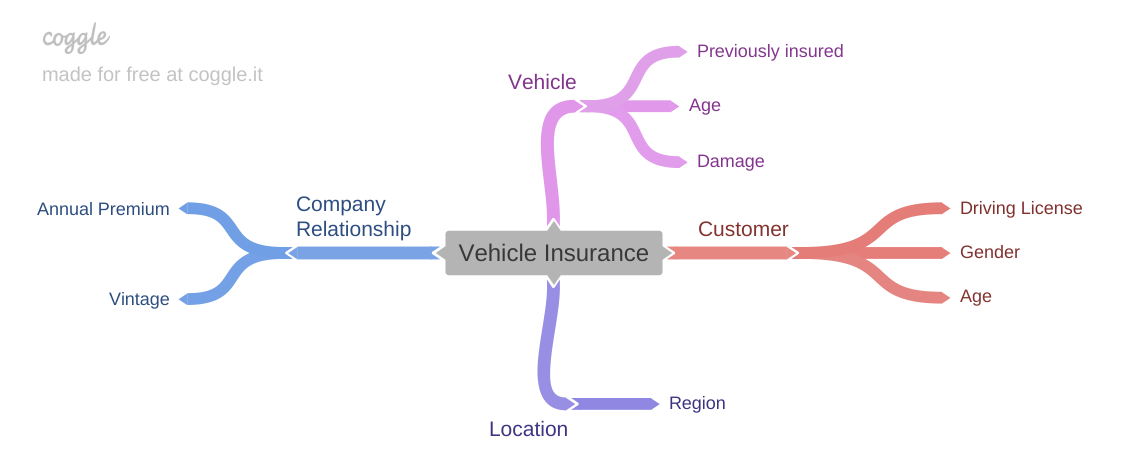

In [178]:
Image('img/Vehicle_Insurance.png')

## Hyphotesis Mind Map

### Customer's Hyphotesis

1. Customers over 40 years old are 50% more interest in vehicle insurance

### Vehicle's Hyphotesis

1. Customer with a newer vehicle are 30% more interest in adquire the vericle insurance than customer with older cars

### Company Relationship's Hyphotesis

1. Customer with less than 30 days in relation with the company are 40% more interest in adquire the vehicle insurance

## Feature Criation

In [179]:
df2.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11,152,1,< 1 Year,Yes,0,23367.0,249,0
1,13,Female,41,15,14,1,1-2 Year,No,1,31409.0,221,0
2,18,Female,25,35,152,1,< 1 Year,No,1,46622.0,299,0
3,31,Female,26,8,160,1,< 1 Year,No,0,2630.0,136,0
4,39,Male,45,8,124,1,1-2 Year,Yes,0,42297.0,264,0


In [180]:
# vericle_age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'bellow_1_year' if x == '< 1 Year' else 
                                                     'between_1_2_year' if x == '1-2 Year' else 
                                                     'over_2_years')

In [181]:
df2.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11,152,1,bellow_1_year,Yes,0,23367.0,249,0
1,13,Female,41,15,14,1,between_1_2_year,No,1,31409.0,221,0
2,18,Female,25,35,152,1,bellow_1_year,No,1,46622.0,299,0
3,31,Female,26,8,160,1,bellow_1_year,No,0,2630.0,136,0
4,39,Male,45,8,124,1,between_1_2_year,Yes,0,42297.0,264,0


# Data Filtering

In [182]:
df3 = df2.copy()

# Exploratory Data Analysis

In [183]:
df4 = df3.copy()

In [184]:
# report = sv.analyze(df4)
# report.show_html()

## Univariate Analysis

### Numerial Variables

#### Age

- Although people between 20 and 30 years old are not usually interest, people between 40 and 50 years old are offen intereset

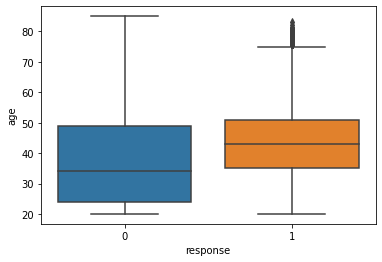

In [185]:
# 'age'
sns.boxplot(x='response',y='age',data=df4);

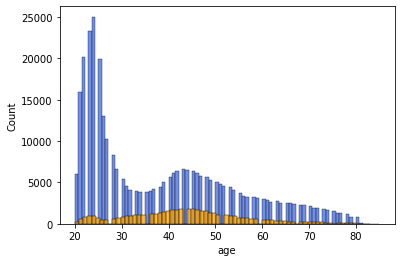

In [186]:
aux00 = df4.loc[df4['response'] == 0, 'age']
aux01 = df4.loc[df4['response'] == 1, 'age']
sns.histplot(aux00,color='royalblue')
sns.histplot(aux01,color='orange');

#### Annual Premium

- The distribuiton of annual premium are very similuar to interest and not interest people. Only the scale of this distribution are diferent

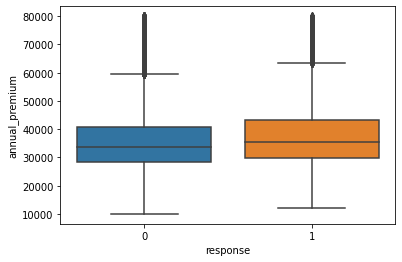

In [187]:
# 'annual_premium'
aux = df4[(df4['annual_premium'] < 80000) & (df4['annual_premium'] > 10000)]
sns.boxplot(x='response',y='annual_premium',data=aux);

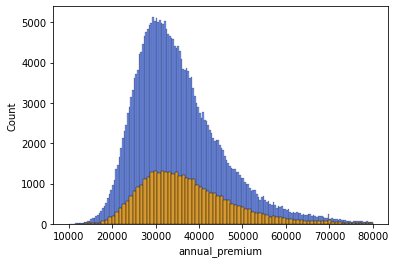

In [188]:
aux00 = aux.loc[aux['response'] == 0, 'annual_premium']
aux01 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot(aux00,color='royalblue')
sns.histplot(aux01,color='orange');

#### Vintage

- The vintage (days that the customer is related with the company) is uniform distribuited

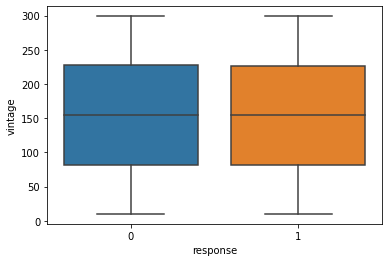

In [189]:
# 'annual_premium'
sns.boxplot(x='response',y='vintage',data=df4);

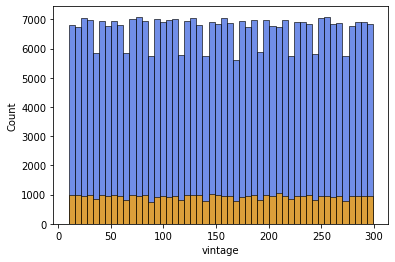

In [190]:
aux00 = df4.loc[df4['response'] == 0, 'vintage']
aux01 = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot(aux00,color='royalblue',bins=50)
sns.histplot(aux01,color='orange',bins=50);

### Categorical Variables

#### Gender

- Mens represents 54% of the elevible customer but represents 61% of whole car insurance interest

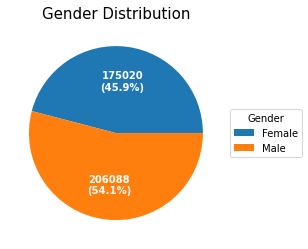

In [191]:
aux2 = pd.DataFrame(df4[['gender','response']].groupby('gender').count()).reset_index()
pie_chart(aux2,'gender',"Gender Distribution",'Gender')

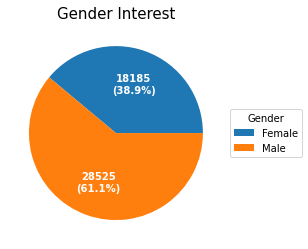

In [192]:
# pie plot
# ax = plt.figure(figsize=(15,6))
aux2 = pd.DataFrame(df4[['gender','response']].groupby('gender').sum()).reset_index()
pie_chart(aux2,'gender',"Gender Interest",'Gender')

#### Driving License

- The majority people has driving license

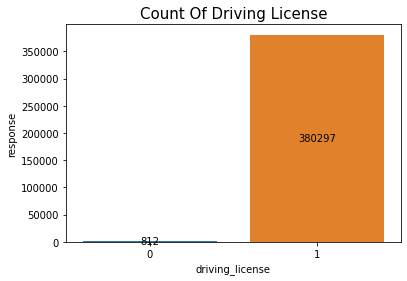

In [193]:
aux1 = df4[['driving_license','response']].groupby('driving_license').count().reset_index()
g = sns.barplot(x = 'driving_license', y = 'response', data = aux1)
g.set_title('Count Of Driving License',fontsize=15)

# incluindo labels nas barras
for i in g.containers:
    g.bar_label(i, color='black', label_type= 'center',fontsize='medium',fmt='%.0f')

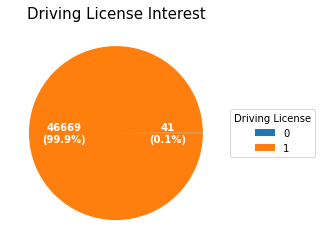

In [194]:
# pie plot
aux1 = pd.DataFrame(df4[['driving_license','response']].groupby('driving_license').sum()).reset_index()
pie_chart(aux1,'driving_license',"Driving License Interest",'Driving License')

#### Region Code

- No region code has a significant majority of interest

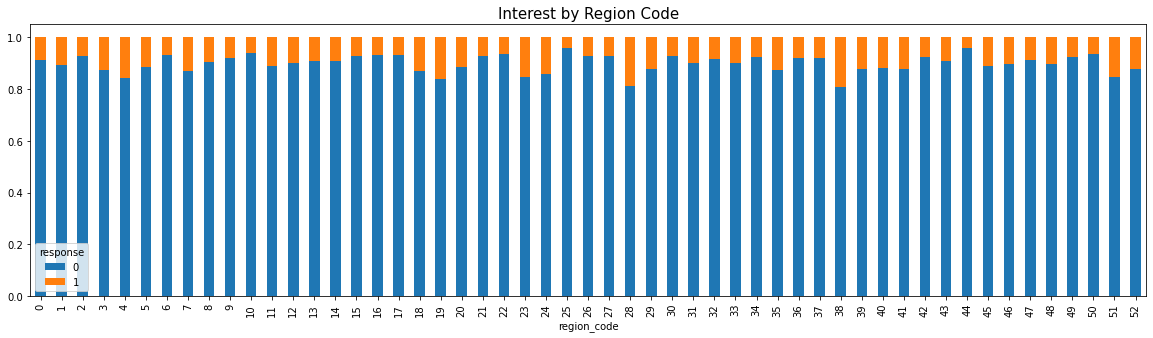

In [195]:
df_grouped = df4[["region_code", "response"]].groupby('region_code').value_counts(normalize=True).unstack('response')
g = df_grouped.plot.bar(stacked=True,figsize=(20,5));
plt.title('Interest by Region Code',fontsize=15);

#### Previously Insured

- Although the similar number of people previously and not previously car insured, the people that haven't previoulsly insurance are the most interested

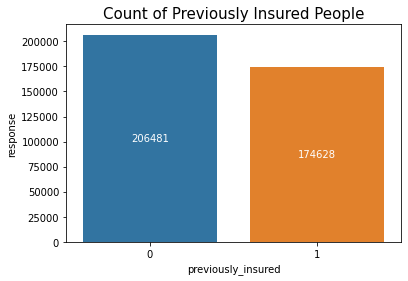

In [196]:
aux1 = df4[['previously_insured','response']].groupby('previously_insured').count().reset_index()
g = sns.barplot(x = 'previously_insured', y = 'response', data = aux1)
g.set_title('Count of Previously Insured People',fontsize=15)

# incluindo labels nas barras
for i in g.containers:
    g.bar_label(i, color='white', label_type= 'center',fontsize='medium',fmt='%.0f')

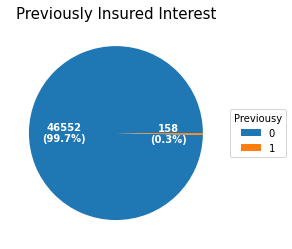

In [197]:
aux1 = pd.DataFrame(df4[['previously_insured','response']].groupby('previously_insured').sum()).reset_index()
pie_chart(aux1,'previously_insured',"Previously Insured Interest",'Previousy')

#### Vericle Age

- The majority of people has cars bellow 2 years old, but the more interested people has cars over 2 years

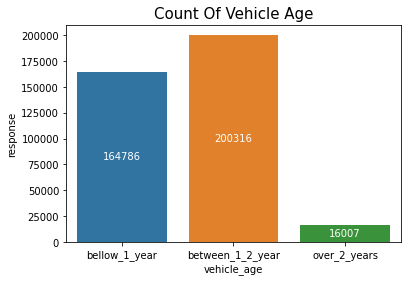

In [198]:
aux1 = df4[["vehicle_age", "response"]].groupby('vehicle_age').count().reset_index()
g = sns.barplot(x = 'vehicle_age', y = 'response', data = aux1)
g.set_title('Count Of Vehicle Age',fontsize=15)

# incluindo labels nas barras
for i in g.containers:
    g.bar_label(i, color='white', label_type= 'center',fontsize='medium',fmt='%.0f')

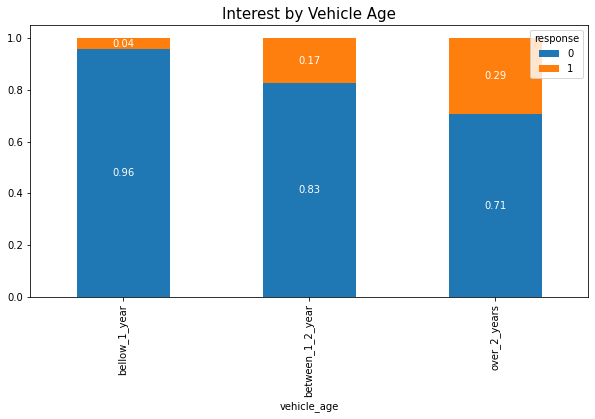

In [199]:
# 'vehicle_age'
df_grouped = df4[["vehicle_age", "response"]].groupby('vehicle_age').value_counts(normalize=True).unstack('response')
g = df_grouped.plot.bar(stacked=True,figsize=(10,5));
g.set_title('Interest by Vehicle Age',fontsize=15)

for i in g.containers:
    g.bar_label(i, color='white', label_type= 'center',fontsize='medium',fmt='%.2f')

#### Policy Sales Channel

- Although the quantity diference of sales channel, no channel has the majority of the interest people

In [200]:
# policy_sales_channel
aux0 = df4[['policy_sales_channel','response']].groupby('policy_sales_channel').sum().reset_index()
aux1 = aux0[aux0['response'] > 40.0]### 4.1.6 Previously Insured

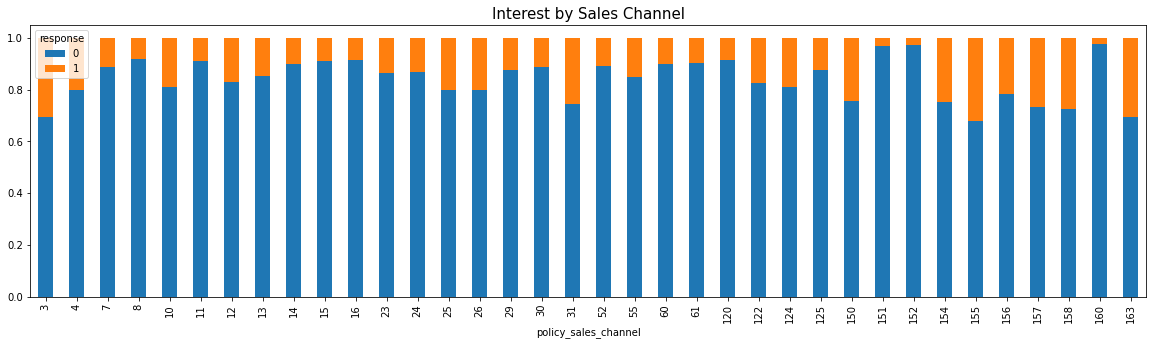

In [201]:
aux = df4[["policy_sales_channel", "response"]].groupby('policy_sales_channel').sum().reset_index()
aux = aux[aux['response'] > 40]

# 'policy_sales_channel'
aux2 = df4[df4['policy_sales_channel'].isin(aux['policy_sales_channel'])]
df_grouped = aux2[["policy_sales_channel", "response"]].groupby('policy_sales_channel').value_counts(normalize=True).unstack('response')
df_grouped.plot.bar(stacked=True,figsize=(20,5));
plt.title('Interest by Sales Channel',fontsize=15);

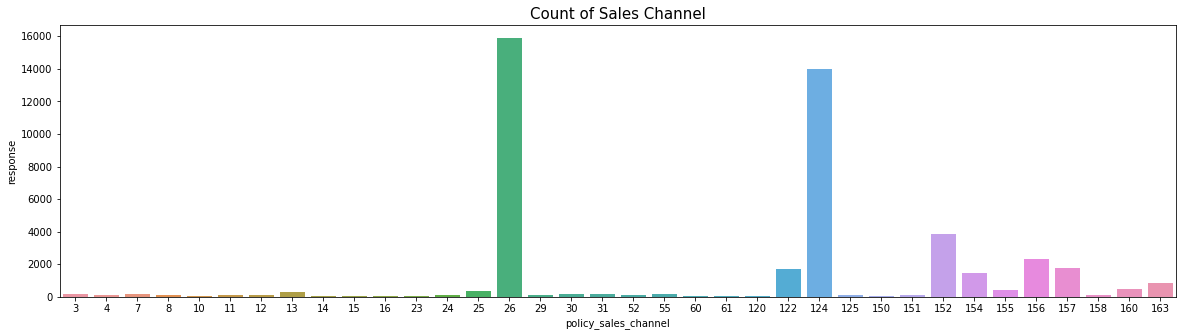

In [202]:
fig = plt.figure(figsize=(20,5))
aux = df4[["policy_sales_channel", "response"]].groupby('policy_sales_channel').sum().reset_index()
aux = aux[aux['response'] > 40]

sns.barplot(data=aux,x='policy_sales_channel',y='response');
plt.title('Count of Sales Channel',fontsize=15);

#### Vehicle Damage

- Although tha simular number of damage and not damage vehicles, people that are more interest has a vehicle damage in the past

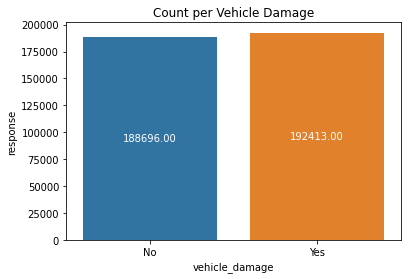

In [203]:
# 'vehicle_damage'
aux1 = df4[['vehicle_damage','response']].groupby('vehicle_damage').count().reset_index()
g = sns.barplot(x = 'vehicle_damage', y = 'response', data = aux1)
g.set_title('Count per Vehicle Damage')

# incluindo labels nas barras
for i in g.containers:
    g.bar_label(i, color='white', label_type= 'center',fontsize='medium',fmt='%.2f')

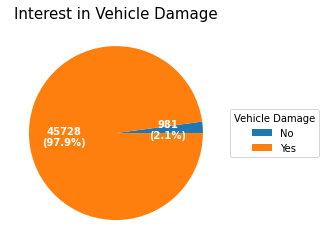

In [204]:
# pie plot
aux1 = pd.DataFrame(df4[['vehicle_damage','response']].groupby('vehicle_damage').sum()).reset_index()
pie_chart(aux1,'vehicle_damage',"Interest in Vehicle Damage",'Vehicle Damage')

## Bivariate Analysis

### H1. Customers over 40 years old are 50% more interest in vehicle insurance

- **False**, customer over 40 years old are 48% more interest in vehicle insurance than others

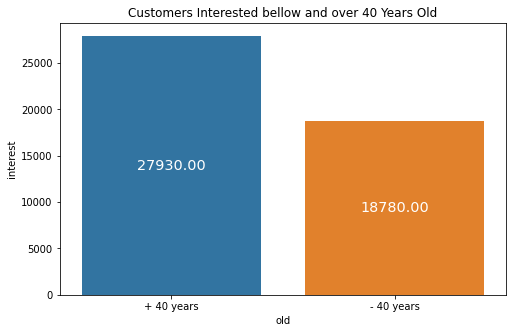

In [205]:
aux = df4[['age','response']].copy()
aux['old'] = df4['age'].apply(lambda x: '+ 40 years' if x > 40 else '- 40 years')
aux = aux[['old','response']].groupby('old').sum().reset_index().rename(columns={'response':'interest'})

fig = plt.figure(figsize=(8,5))
g = sns.barplot(x='old', y='interest', data=aux)
plt.title('Customers Interested bellow and over 40 Years Old')

for i in g.containers:
    g.bar_label(i, color='white', label_type= 'center',fontsize='x-large',fmt='%.2f')

In [206]:
aux['perc'] = (round(aux['interest']/aux['interest'].sum()*100,2)).astype(str) + '%'
aux['diff'] = aux['interest'].rolling(window=2).apply(lambda x: round((x.iloc[0])*100/x.iloc[1]-100,2))
aux

,old,interest,perc,diff
0,+ 40 years,27930,59.79%,NaN
1,- 40 years,18780,40.21%,48.72


### H2. Customer with a newer vehicle are 30% more interest in adquire the vericle insurance than customer with older cars

- **False**, customer with newer vehicle are 81% less interest in adquive the insurance

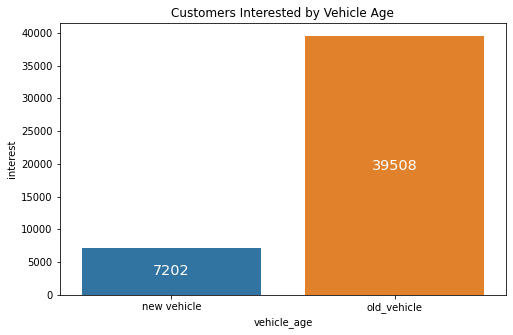

In [207]:
aux = df4[['vehicle_age','response']].copy()
aux['vehicle_age'] = aux['vehicle_age'].apply(lambda x: 'new vehicle' if x == 'bellow_1_year' else 'old_vehicle')
aux = aux.groupby('vehicle_age').sum().reset_index().rename(columns={'response':'interest'})

fig = plt.figure(figsize=(8,5))
g = sns.barplot(x='vehicle_age', y='interest', data=aux)
plt.title('Customers Interested by Vehicle Age')

for i in g.containers:
    g.bar_label(i, color='white', label_type= 'center',fontsize='x-large',fmt='%.0f')

In [208]:
aux['perc'] = (round(aux['interest']/aux['interest'].sum()*100,2)).astype(str) + '%'
aux['diff'] = aux['interest'].rolling(window=2).apply(lambda x: round((x.iloc[0])*100/x.iloc[1]-100,2))
aux

,vehicle_age,interest,perc,diff
0,new vehicle,7202,15.42%,NaN
1,old_vehicle,39508,84.58%,-81.77


### H3. Customer with more days in relation with the company are more interest in adquire the vehicle insurance

- **False**, as longer as the customer relationship with the company are, the lower is the interest

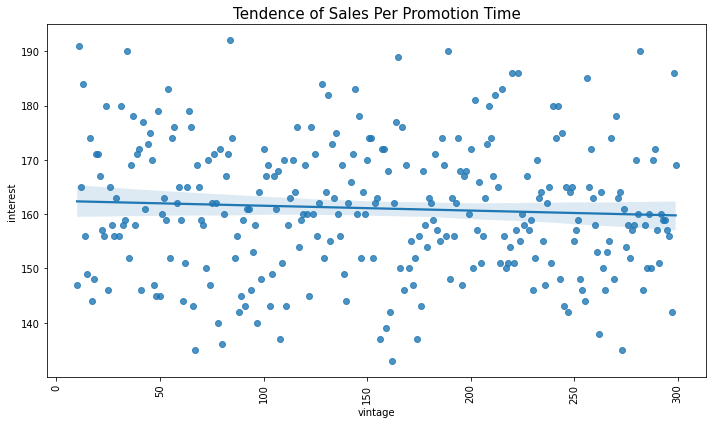

In [209]:
aux = df4[['vintage','response']].copy()
aux = aux.groupby('vintage').sum().reset_index().rename(columns={'response':'interest'})

fig = plt.figure(figsize=(10,6))
sns.regplot(x='vintage', y='interest',data=aux);
plt.xticks(rotation=90);
plt.title('Tendence of Sales Per Promotion Time',fontsize=15)
plt.tight_layout()

# Data Preparation

In [210]:
df5 = df4.copy()

## Split Datasets

In [211]:
X = df4.drop(['response'],axis=1)
y = df4['response'].copy()

### Test and Training

In [212]:
X_train_raw, x_test_raw, Y_train_raw, y_test_raw = ms.train_test_split(X, y, test_size=0.2)

### Training and Validation

In [213]:
x_train, x_validation, y_train, y_validation = ms.train_test_split(X_train_raw, Y_train_raw, test_size=0.2)

data_train = pd.concat([x_train, y_train], axis=1)

In [214]:
print('Total Dimension:                    {}'.format(X.shape[0]))
print('Training Model Dataset Dimension:   {} ({}%)'.format(X_train_raw.shape[0],round((X_train_raw.shape[0]/X.shape[0])*100,2)))
print('Validation Model Dataset Dimension: {} ({}%)'.format(x_test_raw.shape[0],round((x_test_raw.shape[0]/X.shape[0])*100,2)))

print('\nTotal Training Dimension:           {}'.format(X_train_raw.shape[0]))
print('Training Model Dataset Dimension:   {} ({}%)'.format(x_train.shape[0],round((x_train.shape[0]/X_train_raw.shape[0])*100,2)))
print('Validation Model Dataset Dimension: {} ({}%)'.format(x_validation.shape[0],round((x_validation.shape[0]/X_train_raw.shape[0])*100,2)))

Total Dimension:                    381109
Training Model Dataset Dimension:   304887 (80.0%)
Validation Model Dataset Dimension: 76222 (20.0%)

Total Training Dimension:           304887
Training Model Dataset Dimension:   243909 (80.0%)
Validation Model Dataset Dimension: 60978 (20.0%)


## Standardization

In [215]:
ss = pp.StandardScaler()

## annual_premium
data_train['annual_premium'] = ss.fit_transform(data_train[['annual_premium']].values)
pickle.dump(ss,open('C:\\Users\\Notebook\\repos\\Insurance-Cross-Sell\\src\\features\\annual_premium_scaler.pkl','wb'))

## Rescaling

In [216]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

## age
data_train['age'] = mms_age.fit_transform( data_train[['age']].values )
pickle.dump(mms_age,open('C:\\Users\\Notebook\\repos\\Insurance-Cross-Sell\\src\\features\\age_scaler.pkl','wb'))

## vintage
data_train['vintage'] = mms_vintage.fit_transform( data_train[['vintage']].values )
pickle.dump(mms_vintage,open('C:\\Users\\Notebook\\repos\\Insurance-Cross-Sell\\src\\features\\vintage_scaler.pkl','wb'))

## Encoder

### One Hot Enconding

In [217]:
## vehicle_age
data_train = pd.get_dummies(data_train, prefix='vehicle_age',columns=['vehicle_age'])

### Target Enconding

In [218]:
# gender 
target_encode_gender = data_train.groupby('gender')['response'].mean()
data_train.loc[:,'gender'] = data_train['gender'].map(target_encode_gender)
pickle.dump(target_encode_gender,open('C:\\Users\\Notebook\\repos\\Insurance-Cross-Sell\\src\\features\\gender_scaler.pkl','wb'))

# region_code 
target_encode_region_code = data_train.groupby('region_code')['response'].mean()
data_train.loc[:,'region_code'] = data_train['region_code'].map(target_encode_region_code)
pickle.dump(target_encode_region_code,open('C:\\Users\\Notebook\\repos\\Insurance-Cross-Sell\\src\\features\\region_code_scaler.pkl','wb'))

# vehicle damage
target_encode_vehicle_damage = data_train.groupby('vehicle_damage')['response'].mean()
data_train.loc[:,'vehicle_damage'] = data_train['vehicle_damage'].map(target_encode_vehicle_damage)
pickle.dump(target_encode_vehicle_damage,open('C:\\Users\\Notebook\\repos\\Insurance-Cross-Sell\\src\\features\\vehicle_damage_scaler.pkl','wb'))

### Frequency Enconding

In [219]:
## policy_sales_channel 
fe_policy_sales_channel = data_train.groupby('policy_sales_channel').size()/len(data_train)
data_train.loc[:,'policy_sales_channel'] = data_train['policy_sales_channel'].map(fe_policy_sales_channel)
pickle.dump(fe_policy_sales_channel,open('C:\\Users\\Notebook\\repos\\Insurance-Cross-Sell\\src\\features\\policy_sales_channel_scaler.pkl','wb'))

In [220]:
data_train.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,previously_insured,annual_premium,vintage,response,vehicle_age_bellow_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years
242777,34376,0.102989,0.046154,0.071785,0.354505,1,0.005199,1,0.007393,0.650519,0,1,0,0
330329,354007,0.102989,0.723077,0.187809,0.207787,1,0.237748,0,-0.274637,0.615917,0,0,1,0
325662,316030,0.139219,0.800000,0.099099,0.207787,1,0.005199,1,-1.624075,0.903114,0,0,1,0
271349,262241,0.102989,0.030769,0.069808,0.354505,1,0.005199,1,0.378974,0.937716,0,1,0,0
66394,149189,0.139219,0.323077,0.187809,0.003247,1,0.237748,0,1.354621,0.539792,0,0,1,0


## Validation Preparation

In [221]:
x_validation.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage
118340,182804,Male,24,29,152,1,bellow_1_year,No,1,40441.0,108
217348,211831,Female,39,46,124,1,between_1_2_year,Yes,0,26178.0,246
140994,365443,Male,24,41,152,1,bellow_1_year,Yes,0,24651.0,285
82409,276429,Female,71,28,122,1,between_1_2_year,Yes,0,54719.0,52
237267,371071,Female,24,28,122,1,bellow_1_year,No,1,27669.0,53


In [222]:
dict_preparation = {
    'STANDARIZATION':{
        'annual_premium':ss
    },
    'RESCALING': {
        'min_max_scaler':{
            'age':    mms_age,
            'vintage':mms_vintage
        }
    },
    'ENCONDING':{
        'one_hot_enconding':{
            'vehicle_age':'vehicle_age'
        },
        'target_enconding':{
            'gender':         target_encode_gender,
            'region_code':    target_encode_region_code,
            'vehicle_damage': target_encode_vehicle_damage
        },
        'frequency_encoding':{
            'policy_sales_channel':fe_policy_sales_channel
        }
    }
}

In [223]:
def data_preparation(data,dict_preparation):
    for att in list(dict_preparation['STANDARIZATION'].keys()):
        std = dict_preparation['STANDARIZATION'][att]
        data.loc[:,att] = std.transform(data[[att]].values)

    for type_encode in list(dict_preparation['RESCALING'].keys()):
        for att in list(dict_preparation['RESCALING'][type_encode].keys()):
            std = dict_preparation['RESCALING'][type_encode][att]
            data.loc[:,att] = std.transform(data[[att]].values)

    for type_encode in list(dict_preparation['ENCONDING'].keys()):
        for att in list(dict_preparation['ENCONDING'][type_encode].keys()):
            if type_encode == 'one_hot_enconding':
                prefix = dict_preparation['ENCONDING'][type_encode][att]
                columns = dict_preparation['ENCONDING'][type_encode][att]
                data = pd.get_dummies(data, prefix = prefix,columns=[columns])
            else:
                std = dict_preparation['ENCONDING'][type_encode][att]
                data.loc[:,att] = data.loc[:,att].map(std)
                
    # fillna
    data = data.fillna(0)
                
    return data

In [224]:
x_validation = data_preparation(x_validation,dict_preparation)

In [225]:
x_validation.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,previously_insured,annual_premium,vintage,vehicle_age_bellow_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years
118340,182804,0.139219,0.061538,0.119735,0.354505,1,0.005199,1,0.574650,0.339100,1,0,0
217348,211831,0.102989,0.292308,0.104534,0.194040,1,0.237748,0,-0.254750,0.816609,0,1,0
140994,365443,0.139219,0.061538,0.119893,0.354505,1,0.237748,0,-0.343545,0.951557,1,0,0
82409,276429,0.102989,0.784615,0.187809,0.025977,1,0.237748,0,1.404921,0.145329,0,1,0
237267,371071,0.102989,0.061538,0.187809,0.025977,1,0.005199,1,-0.168047,0.148789,1,0,0


# Feature Selection

## Feature Importance

In [226]:
# model definition
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

x_train_n = data_train.drop(['id', 'response'], axis=1)
y_train_n = y_train.values
forest.fit(x_train_n, y_train_n)

# Print the feature ranking
print('Feature ranking')
df = pd.DataFrame()
for i, j in zip(x_train_n.columns, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j},index=[0])
    df= pd.concat([df, aux], axis=0)

df = df.sort_values('importance',ascending=False)
df

Feature ranking


,feature,importance
0,vintage,0.270594
0,annual_premium,0.240157
0,age,0.168550
0,region_code,0.105939
0,vehicle_damage,0.067268
0,policy_sales_channel,0.061168
0,previously_insured,0.057209
0,vehicle_age_bellow_1_year,0.014541
0,vehicle_age_between_1_2_year,0.006307
0,gender,0.005591


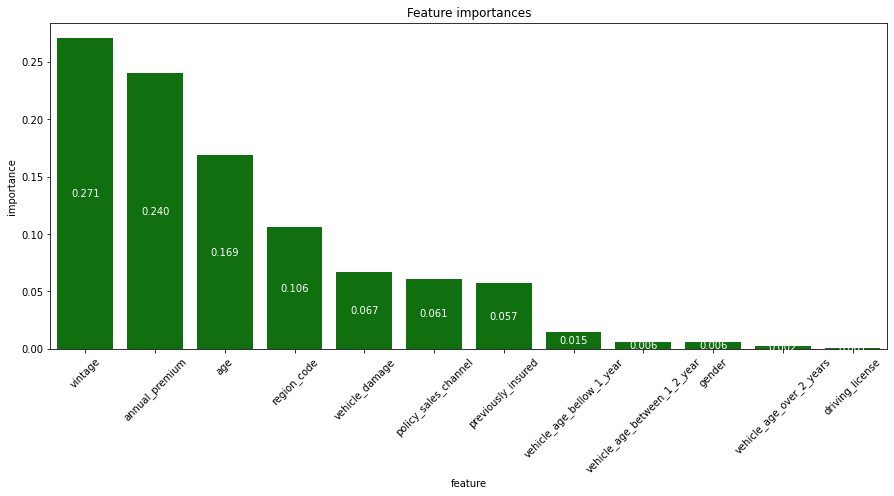

In [227]:
# plot the impurity-based feature importance of the forest

plt.figure(figsize=(15,6))
plt.title('Feature importances')
g = sns.barplot(x='feature',y='importance',data=df,color='green')
plt.xticks(rotation=45)

for i in g.containers:
    g.bar_label(i, color='white', label_type= 'center',fontsize='medium',fmt='%.3f')

# Machine Learning

In [228]:
cols_selected = [
                'vintage',
                'annual_premium',
                'age',
                'region_code',
                'vehicle_damage',
                'policy_sales_channel',
                'previously_insured']

x_train = data_train[cols_selected]
x_val = x_validation[cols_selected]

## KNN

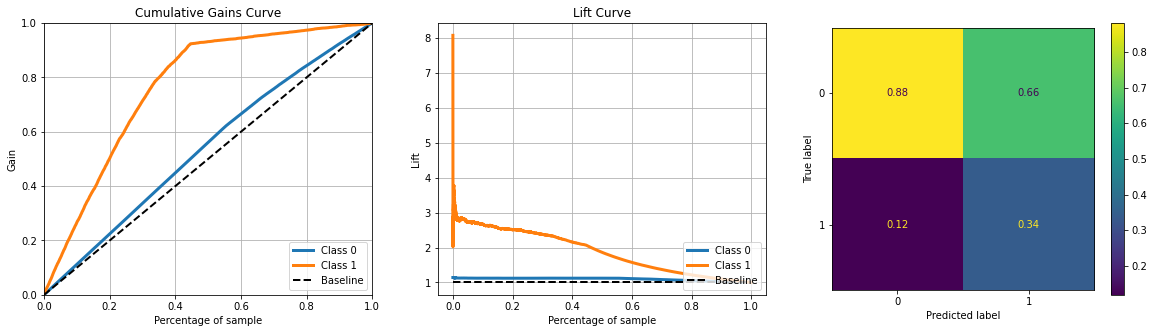

In [229]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=10)

# model training
knn_model.fit(x_train, y_train)

# ==== Model Score 
# model prediction
y_score_knn = knn_model.predict_proba(x_val)
# performance
knn_result_rank = ranking_performance('KNN', x_validation, y_validation,y_score_knn,20000)

# ==== Model Prediction 
# model prediction
y_pred_knn = knn_model.predict(x_val)
# performance
knn_result_class = classification_performance('KNN', y_validation, y_pred_knn)

# plot
fig, ax = plt.subplots(1,3,figsize=(20,5))

# Accumulative Gain 
skplt.metrics.plot_cumulative_gain(y_validation,y_score_knn,ax=ax[0])
skplt.metrics.plot_lift_curve(y_validation,y_score_knn,ax=ax[1]);
plot_confusion_matrix(knn_model, x_val,y_validation,normalize='pred',ax=ax[2])  
plt.show() 

## Logistic Regressor

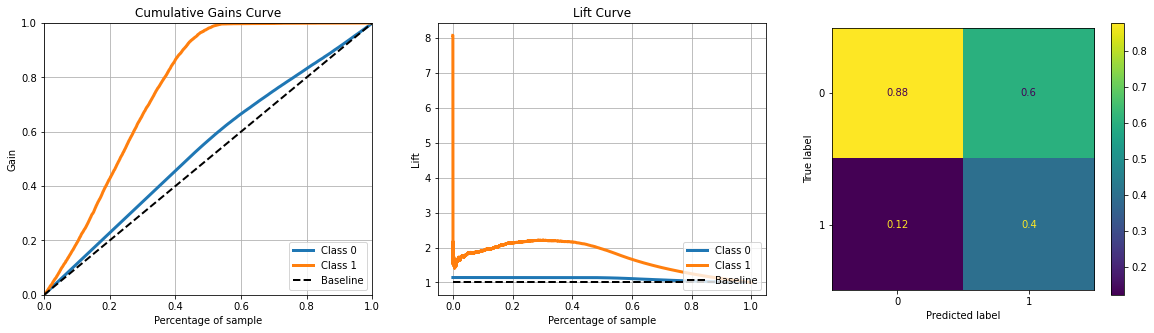

In [230]:
# model definition
lr_model = lm.LogisticRegression(random_state=42,C = 0.001)

# model training 
lr_model.fit(x_train, y_train)

# ==== Model Score 
# model prediction
y_score_lr = lr_model.predict_proba(x_val)
# performance
lr_result_rank = ranking_performance('Logistic Regression', x_validation, y_validation,y_score_lr,20000)

# ==== Model Prediction 
# model prediction
y_pred_lr = lr_model.predict(x_val)
# performance
lr_result_class = classification_performance('Logistic Regression', y_validation, y_pred_lr)

# plot
fig, ax = plt.subplots(1,3,figsize=(20,5))

# Accumulative Gain 
skplt.metrics.plot_cumulative_gain(y_validation,y_score_lr,ax=ax[0])
skplt.metrics.plot_lift_curve(y_validation,y_score_lr,ax=ax[1]);
plot_confusion_matrix(lr_model, x_val,y_validation,normalize='pred',ax=ax[2])  
plt.show() 

## Extra Trees

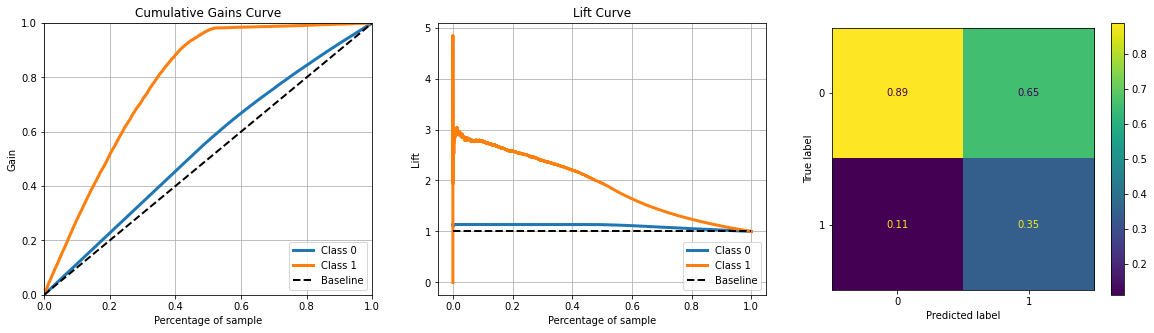

In [231]:
# model definition
et_model = en.ExtraTreesClassifier(n_estimators = 100, n_jobs=-1, random_state=42)

# model fit
et_model.fit(x_train, y_train)

# ==== Model Score 
# model prediction
y_score_et = et_model.predict_proba(x_val)
# performance
et_result_rank = ranking_performance('Extra Tree', x_validation, y_validation,y_score_et,20000)

# ==== Model Prediction 
# model prediction
y_pred_et = et_model.predict(x_val)
# performance
et_result_class = classification_performance('Extra Trees', y_validation, y_pred_et)

# plot
fig, ax = plt.subplots(1,3,figsize=(20,5))

# Accumulative Gain 
skplt.metrics.plot_cumulative_gain(y_validation,y_score_et,ax=ax[0])
skplt.metrics.plot_lift_curve(y_validation,y_score_et,ax=ax[1]);
plot_confusion_matrix(et_model, x_val,y_validation,normalize='pred',ax=ax[2])  
plt.show() 

## XGBoost

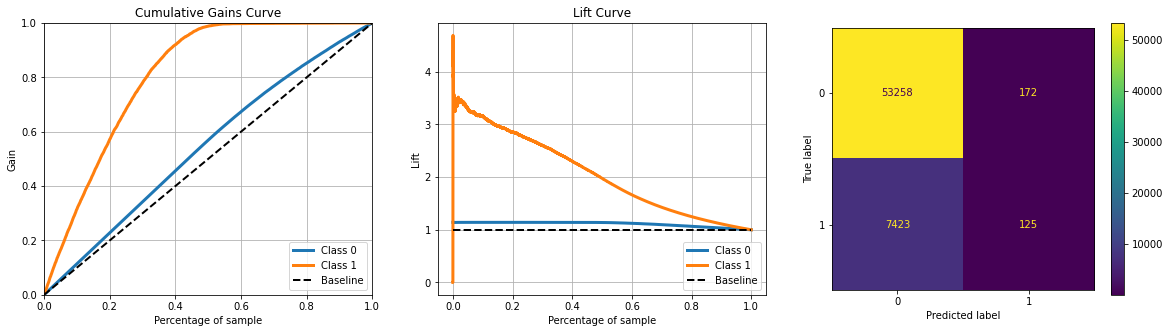

In [253]:
# model definition
xgb_model = xgb.XGBClassifier(n_estimators = 100)

# model fit
xgb_model.fit(x_train,y_train)

# ==== Model Score 
# model prediction
y_score_xgb = xgb_model.predict_proba(x_val)
# performance
xgb_result_rank = ranking_performance('XGBoost', x_validation, y_validation,y_score_xgb,20000)

# ==== Model Prediction 
# model prediction
y_pred_xgb = xgb_model.predict(x_val)
# performance
xgb_result_class = classification_performance('XGBoost', y_validation, y_pred_xgb)

# plot
fig, ax = plt.subplots(1,3,figsize=(20,5))

# Accumulative Gain 
skplt.metrics.plot_cumulative_gain(y_validation,y_score_xgb,ax=ax[0])
skplt.metrics.plot_lift_curve(y_validation,y_score_xgb,ax=ax[1]);
plot_confusion_matrix(xgb_model, x_val,y_validation,ax=ax[2])  
plt.show() 

## LightGBM

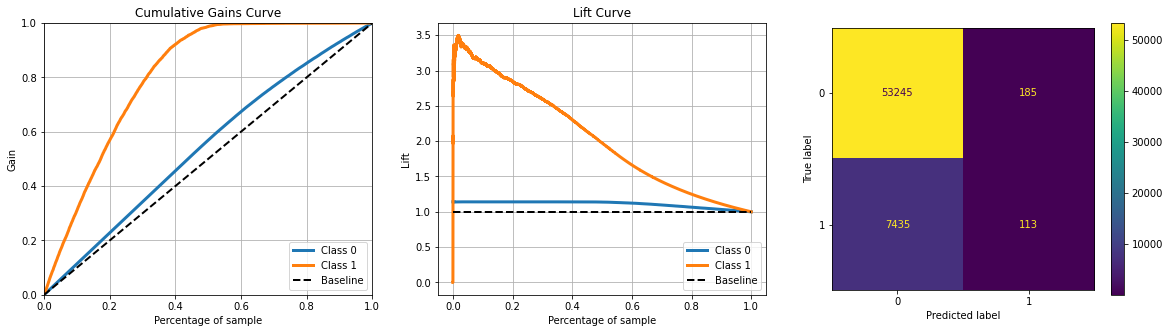

In [252]:
# model definition
lgbm_model = lgb.LGBMClassifier(n_estimators = 600)

# model fit
lgbm_model.fit(x_train,y_train)

# ==== Model Score 
# model prediction
y_score_lgb = lgbm_model.predict_proba(x_val)
# performance
lgb_result_rank = ranking_performance('LightGMB', x_validation, y_validation,y_score_lgb,20000)

# ==== Model Prediction 
# model prediction
y_pred_lgb = lgbm_model.predict(x_val)
# performance
lgb_result_class = classification_performance('LightGMB', y_validation, y_pred_lgb)

# plot
fig, ax = plt.subplots(1,3,figsize=(20,5))

# Accumulative Gain 
skplt.metrics.plot_cumulative_gain(y_validation,y_score_lgb,ax=ax[0])
skplt.metrics.plot_lift_curve(y_validation,y_score_lgb,ax=ax[1]);
plot_confusion_matrix(lgbm_model, x_val,y_validation,normalize='pred',ax=ax[2])  
plt.show() 

## Model Single Performance

In [234]:
pd.concat([knn_result_rank, lr_result_rank, et_result_rank, xgb_result_rank,lgb_result_rank])

,Model Name,Precision at K,Recall at K
0,KNN,0.288836,0.765368
0,Logistic Regression,0.271886,0.720456
0,Extra Tree,0.290435,0.769608
0,XGBoost,0.313134,0.829756
0,LightGMB,0.312184,0.827239


In [235]:
pd.concat([knn_result_class, lr_result_class, et_result_class, xgb_result_class,lgb_result_class])

,Model,Accuracy,Precision,Recall,F1 Score
0,KNN,0.869396,0.341463,0.059353,0.101129
0,Logistic Regression,0.876201,0.400000,0.000265,0.000530
0,Extra Trees,0.860359,0.348004,0.146661,0.206357
0,XGBoost,0.875447,0.420875,0.016561,0.031867
0,LightGMB,0.875037,0.379195,0.014971,0.028804


## Model Real Performance

In [236]:
# knn_cross = cross_validation(data_train,5,'KNN',knn_model,verbose=False)
# lr_cross = cross_validation(data_train,5,'Logistic Regression',lr_model,verbose=False)
# et_cross = cross_validation(data_train,5,'Extra Trees',et,verbose=False)
# xgb_cross = cross_validation(data_train,5,'XGBoost',xgb_model,verbose=False)

# pd.concat([knn_cross, lr_cross, et_cross, xgb_cross])

# Hyperparameters Fine Tuning

In [237]:
# import optuna

# def objective(trial):
#     n_estimators = trial.suggest_int('n_estimators',300, 1000)
#     eta = trial.suggest_float('eta',0.01, 0.05)
#     max_depth = trial.suggest_int('max_depth', 3, 9)
#     subsample = trial.suggest_float('subsample',0.1, 0.9)
#     colsample_bytree = trial.suggest_float('colsample_bytree',0.1,0.9)
    
#     # model definition
#     xgb_model = xgb.XGBClassifier( n_estimators    = n_estimators, 
#                                   eta              = eta, 
#                                   max_depth        = max_depth, 
#                                   subsample        = subsample,
#                                   colsample_bytree = colsample_bytree
#                                  )

#     # model fit
#     xgb_model.fit(x_train,y_train)

#     # ==== Model Prediction 
#     # model prediction
#     y_pred_xgb = xgb_model.predict(x_val)
    
#     return accuracy_score(y_validation,y_pred_xgb)

# study = optuna.create_study()
# study.optimize(objective, n_trials=100)

# study.best_params

In [238]:
best_params = {  'n_estimators': 950,
                 'eta': 0.04204152572401842,
                 'max_depth': 9,
                 'subsample': 0.1190410546753766,
                 'colsample_bytree': 0.8754463017537429  }

# Test Model

### Concat training and validation dataset

In [239]:
# Concat validation Dataframe
validation = pd.concat([x_validation,y_validation],axis=1)

# Concat all training data
data_full = pd.concat([data_train,validation],axis=0)

# Prepare training dataset
x_training_full = data_full.drop(['id','response'],axis=1)
y_training_full = data_full['response']

x_training_full.head(3)

,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,previously_insured,annual_premium,vintage,vehicle_age_bellow_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years
242777,0.102989,0.046154,0.071785,0.354505,1,0.005199,1,0.007393,0.650519,1,0,0
330329,0.102989,0.723077,0.187809,0.207787,1,0.237748,0,-0.274637,0.615917,0,1,0
325662,0.139219,0.800000,0.099099,0.207787,1,0.005199,1,-1.624075,0.903114,0,1,0


### Prepare Test Dataset

In [240]:
x_test = data_preparation(x_test_raw,dict_preparation)[cols_selected]
x_test.head()

,vintage,annual_premium,age,region_code,vehicle_damage,policy_sales_channel,previously_insured
139451,0.605536,1.204011,0.553846,0.187809,0.237748,0.025977,1
270428,0.989619,1.112483,0.169231,0.074742,0.005199,0.354505,1
258817,0.934256,0.775734,0.538462,0.187809,0.237748,0.207787,0
63401,0.256055,0.137475,0.246154,0.070498,0.237748,0.194040,0
335321,0.155709,-1.624075,0.046154,0.072205,0.237748,0.354505,0


### Test Model

In [241]:
# model definition
xgb_model_final = xgb.XGBClassifier(n_estimators      = best_params['n_estimators'],
                                    eta               = best_params['eta'],
                                    max_depth         = best_params['max_depth'],
                                    subsample         = best_params['subsample'],
                                    colsample_bytree  = best_params['colsample_bytree'],
                                    n_jobs=-1)

# model fit
xgb_model_final.fit(x_training_full[cols_selected],y_training_full)
pickle.dump(xgb_model_final,open('C:\\Users\\Notebook\\repos\\Insurance-Cross-Sell\\src\\model\\xgb_model.pkl','wb'))

# ==== Model Score 
# model prediction
y_score_final_xgb = xgb_model_final.predict_proba(x_test[cols_selected])
# performance
xgb_result_final_rank = ranking_performance('XGBoost', x_test, y_test_raw,y_score_final_xgb,20000)

# ==== Model Prediction 
# model prediction
y_pred_final_xgb = xgb_model_final.predict(x_test[cols_selected])
# performance
xgb_result_final_class = classification_performance('XGBoost', y_test_raw, y_pred_final_xgb)

### Test Results

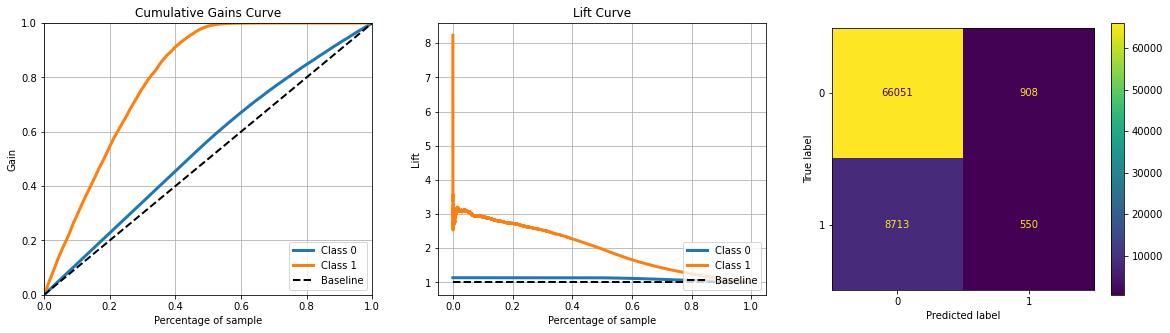

In [251]:
# plot
fig, ax = plt.subplots(1,3,figsize=(20,5))

# Accumulative Gain 
skplt.metrics.plot_cumulative_gain(y_test_raw,y_score_final_xgb,ax=ax[0])
skplt.metrics.plot_lift_curve(y_test_raw,y_score_final_xgb,ax=ax[1]);
plot_confusion_matrix(xgb_model_final, x_test[cols_selected],y_test_raw,ax=ax[2])  
plt.show() 

### Compare Validation and Test Metrics

In [258]:
aux = pd.concat([xgb_result_class,xgb_result_final_class],axis=0)
aux.index = ['Validation', 'Test']
aux

,Model,Accuracy,Precision,Recall,F1 Score
Validation,XGBoost,0.875447,0.420875,0.016561,0.031867
Test,XGBoost,0.873777,0.377229,0.059376,0.102602


# Applying on Production Dataset

In [245]:
data_test = pd.read_csv('test.csv')

cols_old = data_test.columns.tolist() 

# lowercase
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

# rename
data_test.columns = cols_new

X_production = data_preparation(data_test,dict_preparation)

### 8.3 Test Model 

In [246]:
X_production.sample()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,vehicle_age_1-2 Year,vehicle_age_< 1 Year,vehicle_age_> 2 Years
41963,423073,0.139219,0.369231,1,0.187809,0,0.237748,0.616867,0.207787,0.086505,1,0,0


In [247]:
# ==== Model Score 
# model prediction
y_score_xgb_prod = xgb_model_final.predict_proba(X_production[cols_selected])

# ==== Model Classification 
# model prediction
y_pred_xgb_prod = xgb_model_final.predict(X_production[cols_selected])

X_production['score'] = y_score_xgb_prod[:,1].tolist()
X_production['pred'] = y_pred_xgb_prod.tolist()

In [406]:
X_production = X_production.sort_values('score',ascending=False)
X_production.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,vehicle_age_1-2 Year,vehicle_age_< 1 Year,vehicle_age_> 2 Years,score,pred
4332,385442,0.139219,0.338462,1,0.187809,0,0.237748,2.319220,0.004801,0.512111,1,0,0,0.852401,1
48869,429979,0.139219,0.384615,1,0.125509,0,0.237748,-0.178107,0.207787,0.003460,1,0,0,0.822699,1
39772,420882,0.139219,0.169231,1,0.119893,0,0.237748,-0.541605,0.194040,0.622837,1,0,0,0.813654,1
50661,431771,0.139219,0.200000,1,0.075095,0,0.237748,0.143523,0.003210,0.155709,0,0,1,0.813199,1
119252,500362,0.139219,0.276923,1,0.093476,0,0.237748,1.356773,0.194040,0.955017,1,0,0,0.809238,1


# 9.0 Business Result

In [417]:
# Traçando métricas com base na dataset de teste

results = pd.DataFrame()
results['score'] = y_score_final_xgb[:,1].tolist()
results['real'] = y_test_raw.tolist()

# ordering by prediction
results = results.sort_values( 'score', ascending=False )

# Percentage of intereset ( Propensity Score )
results['real_cum'] = results['real'].cumsum() 
results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

# Percentage of Base ( Clients )
results['base'] = range( 1, len( results ) + 1  )
results['base_cum_perc'] = 100*results['base']/len( results )

# Basline model
results['baseline'] = results['base_cum_perc']

In [418]:
results

,score,real,real_cum,real_cum_perc,base,base_cum_perc,baseline
10114,0.905119,1,1,0.010796,1,0.001312,0.001312
56618,0.806466,0,1,0.010796,2,0.002624,0.002624
5896,0.798553,1,2,0.021591,3,0.003936,0.003936
60034,0.786478,0,2,0.021591,4,0.005248,0.005248
62450,0.786328,1,3,0.032387,5,0.006560,0.006560
...,...,...,...,...,...,...,...
27098,0.000034,0,9263,100.000000,76218,99.994752,99.994752
50433,0.000032,0,9263,100.000000,76219,99.996064,99.996064
20582,0.000032,0,9263,100.000000,76220,99.997376,99.997376
4629,0.000026,0,9263,100.000000,76221,99.998688,99.998688


In [419]:
def return_interest_perc(df,calls):
    perc = 100 * calls / len(df)
    return results[results['base_cum_perc'] <= perc]['real_cum_perc'].max()

## Principais Insights sobre os atributos mais relevantes de clientes interessados em adquirir um seguro de automóvel.

1. Pessoas acima de 40 anos são 48% mais interessadas em adquirir o seguro
2. Homens possuem mais interesse em adquirir o seguro do que as mulheres
3. Pessoas que já possuiam seguro de veículo, em quase 00% dos casos, não estavam interessadas em adquirir um segundo seguro
4. Pessoas com o veículo com mais de 2 anos de idade são mais propensas a adquirir o seguro
5. Pessoas que já tiveram danos em seus carros são em sua maioria absoluta mais interessadas em adquirir o seguro

## Qual a porcentagem de clientes interessados em adquirir um seguro de automóvel, se o time de vendas conseguirá contatar fazendo 20.000 ligações?

In [424]:
aux = return_interest_perc(X_production,20000)
print('{}% dos interessados será contatada se a companhia realizar 20 mil ligações'.format(round(float(aux),2)))

43.87% dos interessados será contatada se a companhia realizar 20 mil ligações


## E se a capacidade do time de vendas aumentar para 40.000 ligações, qual a porcentagem de clientes interessados em adquirir um seguro de automóvel o time de vendas conseguirá contatar?

In [425]:
aux = return_interest_perc(X_production,40000)
print('{}% dos interessados será contatada se a companhia realizar 40 mil ligações'.format(round(float(aux),2)))

78.81% dos interessados será contatada se a companhia realizar 40 mil ligações


## Quantas ligações o time de vendas precisa fazer para contatar 80% dos clientes interessados em adquirir um seguro de automóvel?

In [426]:
aux = results[results['real_cum_perc'] <= 80]['base_cum_perc'].max()/100 * len(X_production)
print('O time de vendas teria de fazer {} ligações para atingir 80% dos interessados'.format(int(aux)))

O time de vendas teria de fazer 40961 ligações para atingir 80% dos interessados


## Quantas ligações a companhia deveria fazer para maximixar o lucro?

- Considerando um custo por ligação de RS 4.00 e uma receita por cliente de RS 40.00 temos a seguinte relação:

In [438]:
prod_size = X_production.shape[0]
prod_interest_perc = y_test_raw.sum() / y_test_raw.shape[0]
avg_ticket = 40
cac = 4

##### Revenue curve on baseline model

<AxesSubplot:xlabel='clients_baseline', ylabel='revenue_acumulate'>

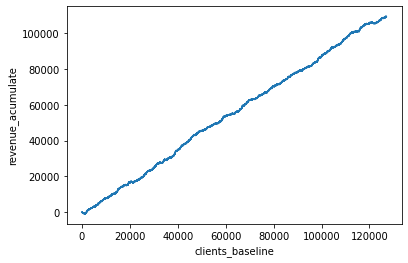

In [439]:
results = pd.DataFrame()
results['score'] = y_score_final_xgb[:,1].tolist()
results['interest'] = y_test_raw.tolist()

# Percetage of base
results['clients'] = range( 1, len( results ) + 1  )
results['clients_cum_perc'] = 100*results['clients']/len( results )

# # Percentage of intereset ( Propensity Score )
results['interest_cum'] = results['interest'].cumsum() 
results['interest_cum_perc'] = 100*results['interest_cum']/results['interest'].sum()

results['clients_baseline'] = results['clients_cum_perc']/100 * prod_size
results['interest_baseline'] = results['interest_cum_perc']/ 100 * prod_size * prod_interest_perc

# gross revenue
results['gross_revenue_acumulate'] = avg_ticket * results['interest_baseline']

# cost
results['cost_acumulate'] = cac * results['clients_baseline']

# revenue 
results['revenue_acumulate'] = results['gross_revenue_acumulate'] - results['cost_acumulate']

# plt.figure( figsize=(12,8))
sns.lineplot( x='clients_baseline', y='revenue_acumulate', data=results )

# results.head(30)

###### Revenue curve on ML Model

<AxesSubplot:xlabel='clients_real', ylabel='revenue_acumulate'>

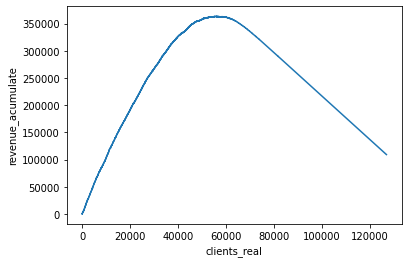

In [440]:
results_prod = pd.DataFrame()
results_prod['score'] = y_score_final_xgb[:,1].tolist()
results_prod['interest'] = y_test_raw.tolist()

# # ordering by prediction
results_prod = results_prod.sort_values( 'score', ascending=False )

# # Percentage of base 
results_prod['clients_cum'] = range( 1, len( results_prod ) + 1  )
results_prod['clients_cum_perc'] = 100 * (results_prod['clients_cum'] / len( results_prod ))

# # Percentage of intereset ( Propensity Score )
results_prod['interest_cum'] = results_prod['interest'].cumsum() 
results_prod['interest_cum_perc'] = 100 * (results_prod['interest_cum'] / results_prod['interest'].sum())

# Generalize to real dataset
results_prod['clients_real'] = results_prod['clients_cum_perc']/100 * prod_size
results_prod['interest_real'] = results_prod['interest_cum_perc']/ 100 * prod_size * prod_interest_perc

# gross revenue
results_prod['gross_revenue_acumulate'] = avg_ticket * results_prod['interest_real']

# cost
results_prod['cost_acumulate'] = cac * results_prod['clients_real']

# revenue 
results_prod['revenue_acumulate'] = results_prod['gross_revenue_acumulate'] - results_prod['cost_acumulate']

# plt.figure( figsize=(12,8))
sns.lineplot( x='clients_real', y='revenue_acumulate', data=results_prod )


##### Optimal result

[[55740.14625699]]


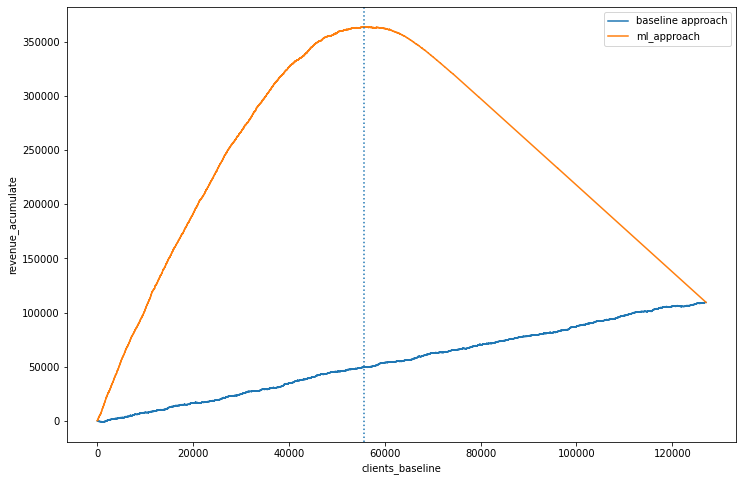

In [441]:
optimal_number_of_clients = results_prod.loc[results_prod['revenue_acumulate'] == results_prod['revenue_acumulate'].max(), ['clients_real']].values

plt.figure( figsize=(12,8))
sns.lineplot( x='clients_baseline', y='revenue_acumulate', data=results )
sns.lineplot( x='clients_real', y='revenue_acumulate', data=results_prod )
plt.legend(['baseline approach','ml_approach'])
plt.axvline(x = optimal_number_of_clients, linestyle = ':') 
print(optimal_number_of_clients)

In [282]:
results_baseline = pd.DataFrame()

# index
results_baseline['index'] = range(1,len(y_test_raw)+1)

# real interest
results_baseline['real'] = y_test_raw.tolist()

# client window
window = 5000
results_baseline['clients_acumulate'] = 0
for i in arange(0,len(y_test_raw)/window,1).astype(int):
    results_baseline['clients_acumulate'][(window)*i:window*(i+1)] = window*(i+1)

# group by client window
df_baseline = results_baseline[['clients_acumulate','real']].groupby('clients_acumulate').agg(clients = ('real','count'),interest= ('real','sum')).reset_index()

df_baseline['clients_perc'] = 100*df_baseline['clients_acumulate'].cumsum()/df_baseline['clients_acumulate'].sum()

# interest
df_baseline['interest_acumulate'] = df_baseline['interest'].cumsum()
# interest
df_baseline['interest_perc'] = 100*df_baseline['interest'].cumsum()/df_baseline['interest'].sum()

# gross revenue
df_baseline['gross_revenue'] = 40 * df_baseline['interest']
df_baseline['gross_revenue_acumulate'] = df_baseline['gross_revenue'].cumsum()

# cost
df_baseline['cost'] = 4 * df_baseline['clients']
df_baseline['cost_acumulate'] = df_baseline['cost'].cumsum()

# revenue 
df_baseline['revenue'] = df_baseline['gross_revenue'] - df_baseline['cost']
df_baseline['revenue_acumulate'] = df_baseline['revenue'].cumsum()

df_baseline[['clients_acumulate','clients_perc','interest','interest_perc','gross_revenue_acumulate','cost_acumulate','revenue_acumulate']]

,clients_acumulate,clients_perc,interest,interest_perc,gross_revenue_acumulate,cost_acumulate,revenue_acumulate
0,5000,0.735294,581,6.248656,23240,20000,3240
1,10000,2.205882,604,12.744676,47400,40000,7400
2,15000,4.411765,600,19.197677,71400,60000,11400
3,20000,7.352941,595,25.596903,95200,80000,15200
4,25000,11.029412,609,32.146698,119560,100000,19560
5,30000,15.441176,658,39.223489,145880,120000,25880
6,35000,20.588235,609,45.773285,170240,140000,30240
7,40000,26.470588,611,52.344590,194680,160000,34680
8,45000,33.088235,613,58.937406,219200,180000,39200
9,50000,40.441176,613,65.530222,243720,200000,43720


In [280]:
results_ml = pd.DataFrame()

# index
results_ml['index'] = range(1,len(y_test_raw)+1)

# score
results_ml['score'] = y_score_final_xgb[:,1].tolist()

# real interest
results_ml['real'] = y_test_raw.tolist()

# order dataset
results_ml = results_ml.sort_values('score',ascending=False)

# client window
window = 5000
results_ml['clients_acumulate'] = 0
for i in arange(0,len(y_test_raw)/window,1).astype(int):
    results_ml['clients_acumulate'][(window)*i:window*(i+1)] = window*(i+1)

# group by client window
df = results_ml[['clients_acumulate','real']].groupby('clients_acumulate').agg(clients = ('real','count'),interest= ('real','sum')).reset_index()

# interest
df['interest_acumulate'] = df['interest'].cumsum()
# interest
df['interest_perc'] = 100*df['interest'].cumsum()/df['interest'].sum()

# gross revenue
df['gross_revenue'] = 40 * df['interest']
df['gross_revenue_acumulate'] = df['gross_revenue'].cumsum()

# cost
df['cost'] = 4 * df['clients']
df['cost_acumulate'] = df['cost'].cumsum()

# revenue 
df['revenue'] = df['gross_revenue'] - df['cost']
df['revenue_acumulate'] = df['revenue'].cumsum()

df[['clients_acumulate','interest','interest_perc','gross_revenue_acumulate','cost_acumulate','revenue_acumulate']]

,clients_acumulate,interest,interest_perc,gross_revenue_acumulate,cost_acumulate,revenue_acumulate
0,5000,1897,20.402237,75880,20000,55880
1,10000,1702,38.707249,143960,40000,103960
2,15000,1497,54.807485,203840,60000,143840
3,20000,1358,69.412777,258160,80000,178160
4,25000,1150,81.781028,304160,100000,204160
5,30000,851,90.933534,338200,120000,218200
6,35000,544,96.784255,359960,140000,219960
7,40000,240,99.365455,369560,160000,209560
8,45000,46,99.860185,371400,180000,191400
9,50000,4,99.903205,371560,200000,171560


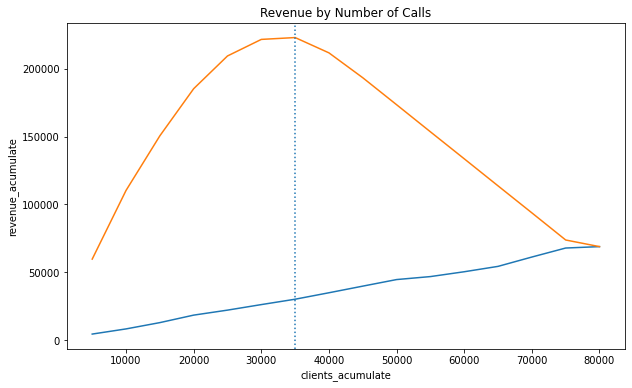

In [162]:
optimal_number_of_clients = df.loc[df['revenue_acumulate'] == max(df['revenue_acumulate']), ['clients_acumulate']].values

plt.figure(figsize=(10,6))
plt.title('Revenue by Number of Calls')
sns.lineplot(x='clients_acumulate',y='revenue_acumulate',data=df_baseline)
sns.lineplot(x='clients_acumulate',y='revenue_acumulate',data=df);
plt.axvline(x = optimal_number_of_clients, linestyle = ':') 

# 10.0 Deployment

In [ ]:
class HealthInsurance():
    def __init__(self):
        self.home_path = 'C:\\Users\\Notebook\\repos\\Insurance-Cross-Sell\\'
        self.annual_premium_scaller      = pickle.load(open(self.path + 'src\\features\\annual_premium_scaller.pkl'))
        self.age_scaler                  = pickle.load(open(self.path + 'src\\features\\age_scaler.pkl'))
        self.vintage_scaler              = pickle.load(open(self.path + 'src\\features\\vintage_scaler.pkl'))
        self.gender_scaler               = pickle.load(open(self.path + 'src\\features\\gender_scaler.pkl'))
        self.region_code_scaler          = pickle.load(open(self.path + 'src\\features\\region_code_scaler.pkl'))
        self.policy_sales_channel_scaler = pickle.load(open(self.path + 'src\\features\\policy_sales_channel_scaler.pkl'))             
    
    def data_cleaning(self, df1):

        # region_code
        df1['region_code'] = df1['region_code'].astype('int64')

        # policy_sales_channel 
        df1['policy_sales_channel'] = df1['policy_sales_channel'].astype('int64')

        return df1

    def feature_engineering(self, df2):

        # vericle_age
        df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'bellow_1_year' if x == '< 1 Year' else 
                                                             'between_1_2_year' if x == '1-2 Year' else 
                                                             'over_2_years')
        return df2
    
    
    def data_preparation(self, df5):

        ss = pp.StandardScaler()

        ## annual_premium
        df5['annual_premium'] = self.annual_premium_scaler.transform(df5[['annual_premium']].values)

        ## 5.3 Rescaling

        ## age
        df5['age'] = self.age_scaler.transform( df5[['age']].values )

        ## vintage
        df5['vintage'] = self.vintage_scaler.transform( df5[['vintage']].values )

        ## 5.4 Encoder
        ### 5.4.1 One Hot Enconding

        ## vehicle_age
        df5 = pd.get_dummies(df5, prefix='vehicle_age',columns=['vehicle_age'])

        ### 5.4.2 Target Enconding

        # gender 
        df5.loc[:,'gender'] = df5['gender'].map(self.gender_scaler)

        # region_code 
        df5.loc[:,'region_code'] = df5['region_code'].map(self.region_code_scaler)

        # vehicle damage
        df5.loc[:,'vehicle_damage'] = df5['vehicle_damage'].map(self.vehicle_damage_scaler)

        ### 5.4.3 Frequency Enconding

        ## policy_sales_channel 
        df5.loc[:,'policy_sales_channel'] = df5['policy_sales_channel'].map(self.policy_sales_channel_scaler)

        cols_selected = [
                'vintage',
                'annual_premium',
                'age',
                'region_code',
                'vehicle_damage',
                'policy_sales_channel',
                'previously_insured']
        
        return df5[cols_selected]

    def get_predict(self, model, original_data, test_data):
        
        # model prediction
        pred = model.predict_proba(test_data)
        
        # join prediction into original data
        original_data['prediction'] = pred
        
        return original_data.to_json(orient='records', date_format='iso')
        

## 10.2. API Handler

In [ ]:
# import pickle
# import pandas as pd
# from flask import Flask, request, Response
# from healthinsurance import HealthInsurance
# import xgboost as xgb

# path = 'C:\\Users\\Notebook\\repos\\Insurance-Cross-Sell\\'
# model = pickle.load(open(path + 'src//model/xgb_model.pkl','rb'))

# app = Flask(__name__)

# @app.route('/predict',methods=['POST'])
# def health_insurance_predict():
#     test_json = request.get_json()
    
#     if test_json:
#         # there is data 
#         if isinstance(test_json, dict): # unique example
#             test_raw = pd.DataFrame(test_json,index=[0])
#         else: # multiple examples
#             test_raw = pd.DataFrame(test_json,columns = test_json[0].keys())
            
#         # Instantiate HeathInsurance class
#         pipeline = HealthInsurance()

#         # data cleaning
#         df1 = pipeline.data_cleaning(test_raw)

#         # feature engineering
#         df2 = pipeline.feature_engineering(df1)

#         # data preparation
#         df3 = pipeline.data_preparation(df2)

#         # prediction
#         df_response = pipeline.get_predict(model,test_raw,df3)
    
#         return df_response
#     else:
#         return Response('{Request is empty}',status=200, mimetype='application/json')

# if __name__ == '__main__':
#     app.run('0.0.0.0')

## 10.3 API Tester

In [163]:
X_test.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,vehicle_age_1-2 Year,vehicle_age_< 1 Year,vehicle_age_> 2 Years,score,pred
101472,482582,0.103976,0.353846,1,0.123240,0,0.237683,1.088655,0.002030,0.020761,1,0,0,0.854421,1
2223,383333,0.103976,0.338462,1,0.187736,0,0.237683,1.754002,0.000154,0.515571,1,0,0,0.806509,1
48755,429865,0.138321,0.200000,1,0.080175,0,0.237683,0.377534,0.007580,0.968858,1,0,0,0.796928,1
86522,467632,0.103976,0.153846,1,0.123240,0,0.237683,-0.173493,0.007580,0.048443,1,0,0,0.796636,1
274,381384,0.103976,0.584615,1,0.187736,0,0.237683,3.648181,0.209107,0.934256,1,0,0,0.787238,1


In [189]:
# loading test dataset
df_test = X[0:10000]
df_test['response'] = y[0:10000]

data = json.dumps(df_test.to_dict(orient='records'))

In [190]:
df_test

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11,152,1,bellow_1_year,Yes,0,23367.0,249,0
1,13,Female,41,15,14,1,between_1_2_year,No,1,31409.0,221,0
2,18,Female,25,35,152,1,bellow_1_year,No,1,46622.0,299,0
3,31,Female,26,8,160,1,bellow_1_year,No,0,2630.0,136,0
4,39,Male,45,8,124,1,between_1_2_year,Yes,0,42297.0,264,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,80090,Male,78,25,30,1,between_1_2_year,No,1,32699.0,11,0
9996,80091,Male,22,15,152,1,bellow_1_year,No,1,30769.0,188,0
9997,80094,Female,42,41,106,1,between_1_2_year,Yes,0,27136.0,13,0
9998,80095,Male,58,28,26,1,between_1_2_year,Yes,0,69939.0,228,0


In [191]:
# url = 'http://192.168.18.4:5000/predict'

# url = 'https://insurance-crosssell-app.herokuapp.com/predict'
url = 'https://insurance-cross-sell-api.onrender.com/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url,data=data,headers=header)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [184]:
pd.DataFrame(r.json(),columns= r.json()[0].keys()).sample(30)

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response,prediction
25,264,Male,0.030769,36,152,1,over_2_years,No,1,-1.621659,0.173010,0,0.000128
5,55,Female,0.369231,28,13,1,over_2_years,Yes,0,0.861746,0.217993,0,0.422391
94,896,Male,0.415385,41,124,1,over_2_years,Yes,0,0.274459,0.221453,1,0.343512
44,424,Female,0.261538,28,152,1,over_2_years,Yes,0,-0.597940,0.269896,0,0.246031
59,542,Male,0.476923,41,12,1,over_2_years,Yes,0,0.050758,0.249135,0,0.246436
83,802,Male,0.046154,28,152,1,over_2_years,No,1,1.587062,0.083045,0,0.000234
95,911,Female,0.015385,28,152,1,over_2_years,Yes,0,0.125634,0.467128,0,0.105596
72,678,Male,0.784615,28,122,1,over_2_years,No,1,0.180892,0.000000,0,0.000625
93,893,Male,0.384615,3,124,1,over_2_years,Yes,1,0.062250,0.598616,0,0.007125
39,370,Male,0.584615,28,23,1,over_2_years,No,1,0.809913,0.290657,0,0.000207
